In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

img_width, img_height = 48, 48  
batch_size = 64

base_dir = os.path.expanduser("~/Python/archive")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

print("Training directory:", train_dir)
print("Testing directory:", test_dir)


Training directory: /Users/joshfleming/Python/archive/train
Testing directory: /Users/joshfleming/Python/archive/test


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    color_mode='rgb',           
    batch_size=batch_size,
    class_mode='categorical',   
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("Class Indices:", train_generator.class_indices)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50

num_classes = train_generator.num_classes

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False  

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', dtype='float32')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


2025-02-04 09:41:11.071233: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-04 09:41:11.071267: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-02-04 09:41:11.071278: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-02-04 09:41:11.071308: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-04 09:41:11.071324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 23850887 (90.98 MB)
Trainable params: 263175 (1.00 MB)
Non-trainable params: 23587712 (89.98 MB)
___________

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_improved_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

epochs = 50

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/50


2025-02-04 09:42:09.625176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


446/448 [============================>.] - ETA: 0s - loss: 2.1212 - accuracy: 0.1960

2025-02-04 09:42:22.284974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - 17s 31ms/step - loss: 2.1200 - accuracy: 0.1962 - val_loss: 1.7889 - val_accuracy: 0.2510 - lr: 0.0010
Epoch 2/50


/Users/joshfleming/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 13s 28ms/step - loss: 1.8573 - accuracy: 0.2254 - val_loss: 1.7906 - val_accuracy: 0.2540 - lr: 0.0010
Epoch 3/50
448/448 [==============================] - 13s 29ms/step - loss: 1.8289 - accuracy: 0.2377 - val_loss: 1.7748 - val_accuracy: 0.2620 - lr: 0.0010
Epoch 4/50
448/448 [==============================] - 13s 28ms/step - loss: 1.8248 - accuracy: 0.2396 - val_loss: 1.7748 - val_accuracy: 0.2683 - lr: 0.0010
Epoch 5/50
448/448 [==============================] - 13s 28ms/step - loss: 1.8058 - accuracy: 0.2473 - val_loss: 1.7784 - val_accuracy: 0.2467 - lr: 0.0010
Epoch 6/50
448/448 [==============================] - 13s 29ms/step - loss: 1.8100 - accuracy: 0.2454 - val_loss: 1.7574 - val_accuracy: 0.2718 - lr: 0.0010
Epoch 7/50
448/448 [==============================] - 13s 29ms/step - loss: 1.7966 - accuracy: 0.2563 - val_loss: 1.7533 - val_accuracy: 0.2860 - lr: 0.0010
Epoch 8/50
448/448 [==============================] - 13s 28ms/step -

In [9]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy:", test_acc)

model.save('fer2013emotionmodel.keras')


112/112 [==============================] - 2s 21ms/step - loss: 1.7118 - accuracy: 0.3058
Test Accuracy: 0.3058035671710968


In [29]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height), color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array

img_path = os.path.expanduser('/Users/joshfleming/Python/archive/test/angry/PrivateTest_1221822.jpg')
new_img = load_and_preprocess_image(img_path)
prediction = model.predict(new_img)
predicted_class = np.argmax(prediction)
print("Predicted Emotion Class:", predicted_class)


1/1 [==============================] - 0s 21ms/step
Predicted Emotion Class: 0


In [18]:
base_model.trainable = True

from tensorflow.keras.optimizers.legacy import Adam
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 20
total_epochs = epochs + fine_tune_epochs  
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  
    callbacks=callbacks
)

Epoch 43/70


2025-02-04 10:25:04.829158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - ETA: 0s - loss: 5.3317 - accuracy: 0.2208

2025-02-04 10:25:49.873341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - 50s 102ms/step - loss: 5.3317 - accuracy: 0.2208 - val_loss: 1155.9432 - val_accuracy: 0.1381 - lr: 1.0000e-05
Epoch 44/70
448/448 [==============================] - 43s 96ms/step - loss: 4.8303 - accuracy: 0.2385 - val_loss: 6.5649 - val_accuracy: 0.2440 - lr: 1.0000e-05
Epoch 45/70
448/448 [==============================] - 43s 97ms/step - loss: 4.5814 - accuracy: 0.2540 - val_loss: 5.4319 - val_accuracy: 0.2822 - lr: 1.0000e-05
Epoch 46/70
448/448 [==============================] - 43s 96ms/step - loss: 4.4249 - accuracy: 0.2642 - val_loss: 4.7250 - val_accuracy: 0.3358 - lr: 1.0000e-05
Epoch 47/70
448/448 [==============================] - 43s 97ms/step - loss: 4.2956 - accuracy: 0.2769 - val_loss: 4.8332 - val_accuracy: 0.3566 - lr: 1.0000e-05
Epoch 48/70
448/448 [==============================] - 44s 98ms/step - loss: 4.1654 - accuracy: 0.2939 - val_loss: 4.6239 - val_accuracy: 0.3708 - lr: 1.0000e-05
Epoch 49/70
448/448 [===============

In [19]:
test_loss, test_acc = model.evaluate(
    test_generator, 
    steps=test_generator.samples // batch_size
)
print("Fine-tuned Test Accuracy: {:.2f}%".format(test_acc * 100))


112/112 [==============================] - 2s 21ms/step - loss: 2.3684 - accuracy: 0.5190
Fine-tuned Test Accuracy: 51.90%


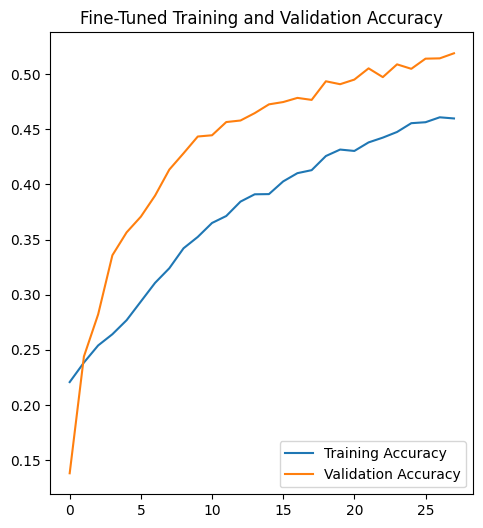

In [23]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Fine-Tuned Training and Validation Accuracy');

